In [62]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig



# Applying 20 NewsGroups Classification

In [4]:
data_train = fetch_20newsgroups(subset='train', shuffle=True)
data_test = fetch_20newsgroups(subset='test', shuffle=True)

labels = data_train.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(data_train.data)

target_names = data_train.target_names

y_train, y_test = data_train.target, data_test.target

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(data_test.data)

Extracting features from the test data using the same vectorizer


In [8]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)
    
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length=2048)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=20, gradient_checkpointing=False, attention_window = 512)


train_encodings = tokenizer(data_train.data, truncation=True, padding=True, max_length=2048)
valid_encodings = tokenizer(data_test.data, truncation=True, padding=True, max_length=2048)
    
train_dataset = NewsGroupsDataset(train_encodings, data_train.target)
valid_dataset = NewsGroupsDataset(valid_encodings, data_test.target)

model.to(device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight'

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc,}

training_args = TrainingArguments(
    output_dir = '../results/sentihood/NewsGroups/',
    num_train_epochs =10,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 8,    
    per_device_eval_batch_size=4,
    evaluation_strategy = "steps",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps = 4,
    fp16 = True,
    logging_dir='../results/sentihood/NewsGroups/logs',
    dataloader_num_workers = 0,
    run_name = 'longformer-classification-updated-rtx3090_paper_replication_2_warm'
)

In [10]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=valid_dataset,          
    compute_metrics=compute_metrics,     
)

trainer.train()
trainer.evaluate()

Using amp half precision backend
/home/haoyu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11314
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 8
  Total optimization steps = 880
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
/home/haoyu/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Step,Training Loss,Validation Loss,Accuracy
4,2.996900,3.001111,0.054567


Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
/home/haoyu/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  w

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

KeyboardInterrupt: 

In [11]:
model_path = "model/20newsgroups-longformer"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in model/20newsgroups-longformer/config.json
Model weights saved in model/20newsgroups-longformer/pytorch_model.bin
tokenizer config file saved in model/20newsgroups-longformer/tokenizer_config.json
Special tokens file saved in model/20newsgroups-longformer/special_tokens_map.json


('model/20newsgroups-longformer/tokenizer_config.json',
 'model/20newsgroups-longformer/special_tokens_map.json',
 'model/20newsgroups-longformer/vocab.json',
 'model/20newsgroups-longformer/merges.txt',
 'model/20newsgroups-longformer/added_tokens.json',
 'model/20newsgroups-longformer/tokenizer.json')

# Obtain newsgroup predictions for PerSent dataset from fine-tuned Longformer

In [64]:
'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is dev.csv
'''

train_data = pd.read_csv("../datasets/persent/dev.csv")
train_data.head()

,DOCUMENT_INDEX,TITLE,TARGET_ENTITY,DOCUMENT,MASKED_DOCUMENT,TRUE_SENTIMENT,Paragraph0,Paragraph1,Paragraph2,Paragraph3,...,Paragraph6,Paragraph7,Paragraph8,Paragraph9,Paragraph10,Paragraph11,Paragraph12,Paragraph13,Paragraph14,Paragraph15
0,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,Neutral,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3361,Paraguay leader sacks chief of armed forces,Fernando Lugo,Lugo a former Catholic bishop who assumed off...,Lugo a former Catholic bishop who assumed off...,Positive,Positive,Positive,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3362,Tennis: Nadal hopes to see Spain win World Cup,Rafael Nadal,Spanish Wimbledon winner Rafael Nadal said Sun...,[TGT] said Sunday [TGT] would love to go to th...,Positive,Positive,Positive,Positive,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3363,White House picks new cyber coordinator,Howard A. Schmidt,In a letter posted on the White House web site...,In a letter posted on the White House web site...,Positive,Positive,Neutral,Positive,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3364,MORRIS PICKS HIS QB BUT KEEPS IT QUIET,MORRIS,TAMPA At least Raheem Morris finally has the ...,TAMPA At least Raheem Morris finally has the ...,Positive,Neutral,Positive,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
target_names = data_train.target_names

def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=2048, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()]

def get_max_prob(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=2048, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return max(probs[0].tolist())

train_data['prob_max'] = train_data['DOCUMENT'].apply(get_max_prob)
train_data['topic'] = train_data['DOCUMENT'].apply(get_prediction)

Initializing global attention on CLS token...
Input ids are automatically padded from 249 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 219 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 191 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 150 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 377 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 179 to 512 to be a multipl

Initializing global attention on CLS token...
Input ids are automatically padded from 66 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 288 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 39 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 185 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 110 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 240 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 305 to 512 to be a multiple 

Input ids are automatically padded from 697 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 840 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 268 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 253 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 274 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 451 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 428 to 512 to be a multiple of `config.attention_window`: 512
Initiali

Initializing global attention on CLS token...
Input ids are automatically padded from 197 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 626 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 397 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 271 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 279 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 195 to 512 to be a multip

KeyboardInterrupt: 

# Map label to 6 groups

In [20]:
topic_groups = {'computer': ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x'], 'recreation': ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'], 'science': ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'], 'sale': ['misc.forsale'], 'politics': ['talk.politics.misc', 'talk.politics.guns', 'talk.politics.mideast'], 'religion': ['talk.religion.misc', 'alt.atheism', 'soc.religion.christian']}
# train_data = pd.read_csv('../datasets/persent/random_test_longformer_topic.csv')

topic_mapping = {}
for key, val in topic_groups.items():
    for sub in val:
        topic_mapping[sub] = key
        
train_data['group'] = train_data['topic'].apply(lambda x: topic_mapping[x])

def group_w_threshold(row):
    if row['prob_max'] <0.5:
        return 'general'
    else:
        return row['group']

train_data['group'] = train_data.apply(group_w_threshold, axis=1)


In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is dev

train_data.to_csv('../datasets/persent/dev_longformer_topic_nocopy.csv', index=False)

# Create 4-aspect dataset

In [21]:
train_data4 = train_data.loc[train_data['group'].isin(['politics', 'general', 'recreation', 'science'])]

train_data4.reset_index(inplace=True)
train_data4.drop(['index'], axis=1, inplace=True)

train_data4_new = train_data4[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT']]
train_data4_new = train_data4_new.loc[train_data4_new.index.repeat(4)]
groups = ['politics', 'general', 'recreation', 'science'] * (train_data4_new.shape[0] // 4)
train_data4_new['group'] = groups
train_data4_new['prob_max'] = np.nan
train_data4_new['sentiment'] = np.nan
train_data4_new.reset_index(inplace=True)
train_data4_new.drop(['index'], axis=1, inplace=True)

for i in range(train_data4.shape[0]):
    temp_ind = train_data4_new.loc[(train_data4_new['DOCUMENT_INDEX']==train_data4['DOCUMENT_INDEX'][i]) & (train_data4_new['group']==train_data4['group'][i])].index[0]
    train_data4_new.loc[temp_ind, 'sentiment'] = train_data4['TRUE_SENTIMENT'][i]
    train_data4_new.loc[temp_ind, 'prob_max'] = train_data4['prob_max'][i]
    
train_data4_new['sentiment'].fillna('None', inplace=True)
train_data4_new['context'] = '[TGT] - '+ train_data4_new['group']



In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is dev

train_data4_new.to_csv('../datasets/persent/dev_longformer_4topics.csv', index=False)

# Create 7-aspect dataset

In [26]:
train_data7 = train_data[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT', 'group', 'TRUE_SENTIMENT', 'prob_max']]
train_data7_new = train_data7.loc[train_data7.index.repeat(7)]
groups = ['politics', 'recreation', 'computer', 'religion', 'science', 'sale', 'general'] * (train_data7_new.shape[0] // 7)
train_data7_new['group'] = groups
train_data7_new['prob_max'] = np.nan
train_data7_new['sentiment'] = np.nan
train_data7_new.reset_index(inplace=True)
train_data7_new.drop(['index'], axis=1, inplace=True)

for i in range(train_data7.shape[0]):
    temp_ind = train_data7_new.loc[(train_data7_new['DOCUMENT_INDEX']==train_data7['DOCUMENT_INDEX'][i]) & (train_data7_new['group']==train_data7['group'][i])].index[0]
    train_data7_new.loc[temp_ind, 'sentiment'] = train_data7['TRUE_SENTIMENT'][i]
    train_data7_new.loc[temp_ind, 'prob_max'] = train_data7['prob_max'][i]
    
train_data7_new['sentiment'].fillna('None', inplace=True)
train_data7_new['context'] = '[TGT] - '+ train_data7_new['group']


In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is dev

train_data7_new.to_csv('../datasets/persent/dev_longformer_7topics.csv', index=False)

# Create paragraph dataset

In [49]:
def aspect_para_generation(data, data_w_para):
    
    data['paras'] = data['MASKED_DOCUMENT'].apply(lambda x: x.split('\n'))
    paras = list(data['paras'])
    
    paras1, sents, aspects = [], [], []

    for i in range(data.shape[0]):
        current_doc_id =  data['DOCUMENT_INDEX'][i]
        if len(paras[i]) > 16:
            sents.extend(data_w_para.iloc[data_w_para.loc[data_w_para['DOCUMENT_INDEX']==current_doc_id].index[0], 6:22])
            aspects.extend([data['group'][i]]*16)
            paras1.extend(paras[i][:16])
        else:
            sents.extend(data_w_para.iloc[data_w_para.loc[data_w_para['DOCUMENT_INDEX']==current_doc_id].index[0], 6:6+len(paras[i])])
            aspects.extend([data['group'][i]]*len(paras[i]))
            paras1.extend(paras[i])
    df2 = pd.DataFrame({'Paragraph':paras1, 'Sentiment':sents, 'Aspects':aspects})                            
    df2['Word_Count'] = df2['Paragraph'].apply(lambda x: len(x.split()))
    df2['Contains_Target'] = df2['Paragraph'].apply(lambda x: '[TGT]' in x)
    df2 = df2.loc[(df2['Word_Count']<=128) & (df2['Contains_Target'])]
    df2.reset_index(inplace=True, drop=True)
    df2['Aspects'] = df2['Aspects'].astype(str)
    df2.drop(columns=['Word_Count', 'Contains_Target'], inplace=True)
    df2['Context'] = '[TGT] - '+ df2['Aspects']
    
    df2.dropna(inplace=True)
    df2.reset_index(inplace=True, drop=True)

    return df2

data_para4 = aspect_para_generation(train_data4_new, train_data)
data_para7 = aspect_para_generation(train_data7_new, train_data)



In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is dev

data_para4.to_csv('../datasets/persent/dev_para_4aspects_128tokens.csv', index=False)
data_para7.to_csv('../datasets/persent/dev_para_7aspects_128tokens.csv', index=False)

# Create dataset for pure Longformer model

In [51]:
def aspect_longformer_generation(data):
    df1 = data.loc[data.index.repeat(4)]

    labels = ['None', 'Neutral', 'Negative', 'Positive']
    label_map = dict(zip(labels, range(4)))

    df1['sentiment'] = labels * (df1.shape[0] // 4)
    df1['label'] = np.nan
    df1.reset_index(inplace=True, drop=True)

    for i in range(data.shape[0]):
        temp_label = label_map[data.loc[i, 'sentiment']]
        df1.loc[i * 4 + temp_label, 'label'] = 1
        
    df1['label'].fillna(0, inplace=True)
    df1['auxi_sent'] = 'the polarity of the aspect ' + df1['group'] + ' of [TGT] is ' + df1['sentiment'] + '.'
    return df1

data_long4 = aspect_longformer_generation(train_data4_new)
data_long7 = aspect_longformer_generation(train_data7_new)

In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is dev

data_long4.to_csv('../datasets/persent/dev_longformer_4topics_auxiliary.csv', index=False)
data_long7.to_csv('../datasets/persent/dev_longformer_7topics_auxiliary.csv', index=False)

# View data distribution regarding aspects

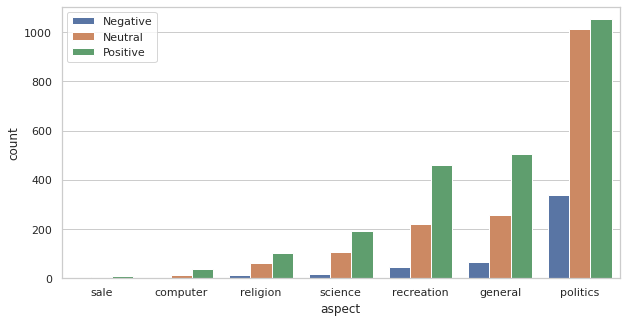

In [72]:
df1 = pd.read_csv('../datasets/persent/dev_longformer_topic_nocopy.csv')
df2 = pd.read_csv('../datasets/persent/train_longformer_topic_nocopy.csv')
df3 = pd.read_csv('../datasets/persent/random_test_longformer_topic_nocopy.csv')

df = pd.concat([df1, df2, df3], ignore_index=True)
df_new = df.groupby(by=['group', 'TRUE_SENTIMENT']).count()
df_new.reset_index(inplace=True)
df_new = df_new[['group', 'TRUE_SENTIMENT', 'DOCUMENT_INDEX']]
df_new.columns = ['aspect', 'sentiment', 'count']

df_new2 = df.groupby(by=['group']).count()
df_new2.reset_index(inplace=True)
df_new2 = df_new2[['group', 'DOCUMENT_INDEX']]
df_new2.columns = ['aspect', 'count']
df_new2.sort_values(by=['count'], inplace=True)

fig, ax  = plt.subplots(1,1, figsize = (10,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='aspect', y='count', data=df_new, hue='sentiment', order=list(df_new2.aspect))
# plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.legend(loc='upper left')

plt.show()